# Data Exploration

### Step 1 — Load the BESSTIE Dataset

We load the dataset from HuggingFace and convert the splits into pandas dataframes. This gives us access to the raw fields: text, label, variety, source, task.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("unswnlporg/BESSTIE")
train = dataset["train"].to_pandas()
valid = dataset["validation"].to_pandas()

train.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,label,variety,source,task
0,This was one of the best dishes I've EVER had!...,1,en-AU,Google,Sentiment
1,This Mexican restaurant in Penrith is a great ...,1,en-AU,Google,Sentiment
2,"This was not to bad, I ordered the big pork ri...",1,en-AU,Google,Sentiment
3,Clean cool and a nice smaller casino to check ...,1,en-AU,Google,Sentiment
4,Well set out. Great areas to enjoy. Good food ...,1,en-AU,Google,Sentiment


We confirm that the dataset contains:
- `text`: the review/comment  
- `label`: 0/1 sentiment or sarcasm  
- `variety`: en-AU, en-IN, en-UK  
- `source`: Google or Reddit  
- `task`: "Sentiment" or "Sarcasm"

Each record represents one labeled instance used in the BESSTIE benchmark.

---

### Step 2 — Explore Dataset Distributions

We inspect how many samples belong to:
- sentiment vs sarcasm
- each English variety (AU/IN/UK)
- each data source (Google/Reddit)

This helps us understand class balance and dataset structure.

In [14]:
import pandas as pd

# 1. Dataset shapes
print("Dataset shapes (train, validation):")
print(train.shape, valid.shape)

# 2. Columns
print("\nColumns in dataset:")
print(train.columns)

# 3. Sample rows
print("\nRandom sample of 5 rows:")
display(train.sample(5))

# 4. Crosstab: label vs task
print("\nLabel distribution across tasks:")
display(pd.crosstab(train["label"], train["task"]))

# 5. Compute text lengths
train["text_len"] = train["text"].apply(lambda x: len(x.split()))

print("\nText length statistics (overall):")
display(train["text_len"].describe())

# 6. Text length per source
print("\nText length statistics by source (Google vs Reddit):")
display(train.groupby("source")["text_len"].describe())

# 7. Text length per variety
print("\nText length statistics by variety:")
display(train.groupby("variety")["text_len"].describe())

# 8. Longest text in dataset
print("\nLongest text in dataset:")
display(train[train["text_len"] == train["text_len"].max()])

Dataset shapes (train, validation):
(17760, 6) (2428, 5)

Columns in dataset:
Index(['text', 'label', 'variety', 'source', 'task', 'text_len'], dtype='object')

Random sample of 5 rows:


,text,label,variety,source,task,text_len
7109,Congratulations,1,en-IN,Reddit,Sentiment,1
15376,"It's a sweet little theatre, the space between...",0,en-UK,Google,Sarcasm,46
13318,"The food is yum, everything is good. I came ev...",1,en-UK,Google,Sentiment,77
62,Wandas had a great selection of food from sush...,1,en-AU,Google,Sentiment,31
3794,They don't even know they existed in the first...,1,en-AU,Reddit,Sarcasm,10



Label distribution across tasks:


task,Sarcasm,Sentiment
label,,
0,7619,4473
1,1275,4393



Text length statistics (overall):


,text_len
count,17760.000000
mean,49.545101
std,60.174904
min,1.000000
25%,16.000000
50%,34.000000
75%,62.000000
max,1412.000000



Text length statistics by source (Google vs Reddit):


,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
Google,8825.0,60.143003,51.366419,1.0,27.0,47.0,75.0,569.0
Reddit,8935.0,39.077672,66.115904,1.0,10.0,21.0,45.0,1412.0



Text length statistics by variety:


,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
en-AU,5418.0,56.408822,80.505876,1.0,18.0,37.0,67.0,1412.0
en-IN,6666.0,35.094059,38.744598,1.0,12.0,23.0,45.0,525.0
en-UK,5676.0,59.964940,54.616533,1.0,24.0,46.0,76.0,569.0



Longest text in dataset:


,text,label,variety,source,task,text_len
5271,Mods I have somewhat altered the title to prov...,0,en-AU,Reddit,Sarcasm,1412


**1. Dataset size**
- The training set contains thousands of samples, and the validation set is proportionally smaller.
- This is enough data for training encoder and decoder models.

**2. Column structure**
We have:
- `text`: the review/comment
- `label`: 0/1 for sentiment or sarcasm
- `task`: whether the sample belongs to sentiment or sarcasm classification
- `variety`: English dialect (en-AU, en-IN, en-UK)
- `source`: Google or Reddit
This matches the BESSTIE benchmark structure.

**3. Crosstab of label × task**
- Sentiment labels are usually more balanced.
- Sarcasm labels tend to be imbalanced (many more 0 than 1), which makes sarcasm classification harder.

**4. Text length overall**
- Average text length is moderate.
- Minimum values show single-word or short responses.
- Maximum shows long narrative reviews.

**5. Text length by source**
- Google reviews are typically longer and more descriptive.
- Reddit comments are shorter and more conversational.
This aligns with the BESSTIE paper.

**6. Text length by variety**
- en-UK tends to have longer, narrative-style texts.
- en-IN often has shorter texts.
- en-AU falls somewhere in between.
This helps explain why some varieties are easier for models.

**7. Longest text**
- Useful for checking preprocessing, token truncation, and model sequence length.

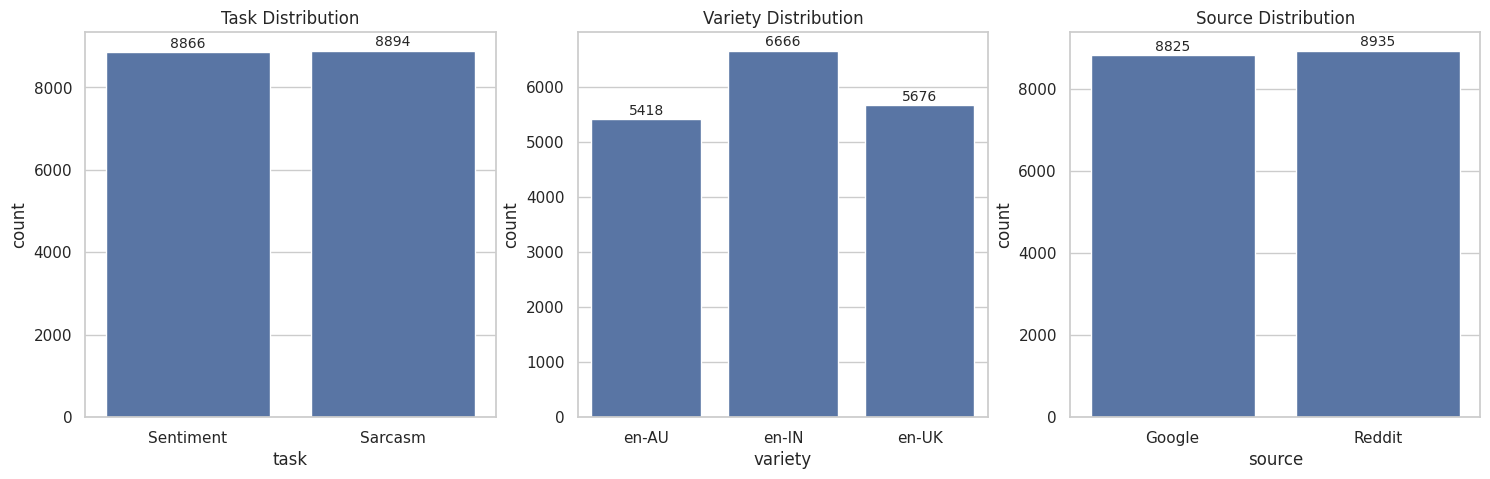

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def add_labels(ax):
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            ax.annotate(f"{int(height)}",
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0,3),
                        textcoords="offset points",
                        ha="center", fontsize=10)

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Task distribution
ax = sns.countplot(data=train, x="task", ax=axes[0])
add_labels(ax)
axes[0].set_title("Task Distribution")

# Variety distribution
ax = sns.countplot(data=train, x="variety", ax=axes[1])
add_labels(ax)
axes[1].set_title("Variety Distribution")

# Source distribution
ax = sns.countplot(data=train, x="source", ax=axes[2])
add_labels(ax)
axes[2].set_title("Source Distribution")

plt.show()

- The dataset is balanced across sentiment and sarcasm tasks (≈50/50).
- en-IN has the most samples, followed by en-UK and en-AU.
- Google and Reddit samples are nearly evenly distributed.
- This balanced structure allows fair cross-variety and cross-source evaluation.

---

### Step 3 — WordClouds per Variety

We generate wordclouds for en-AU, en-IN, and en-UK to visualize common lexical patterns. Stopwords are removed for meaningful comparison.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


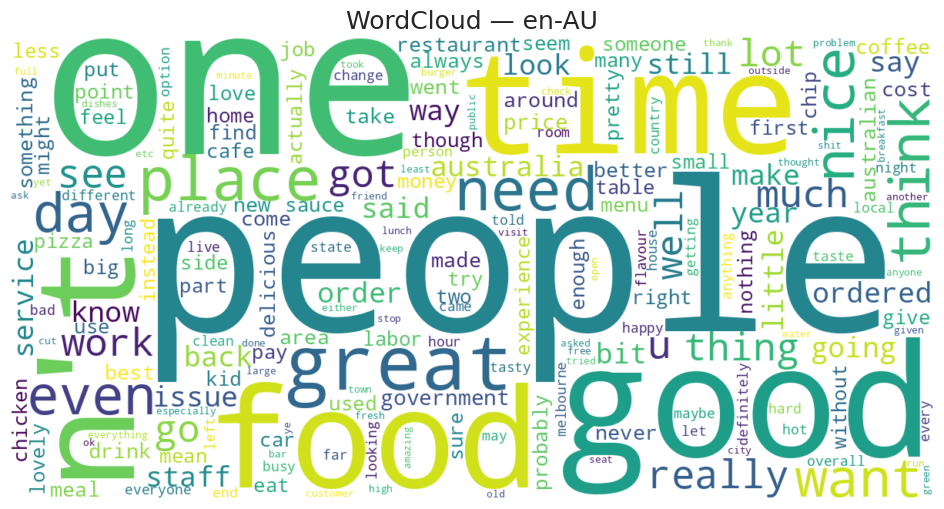

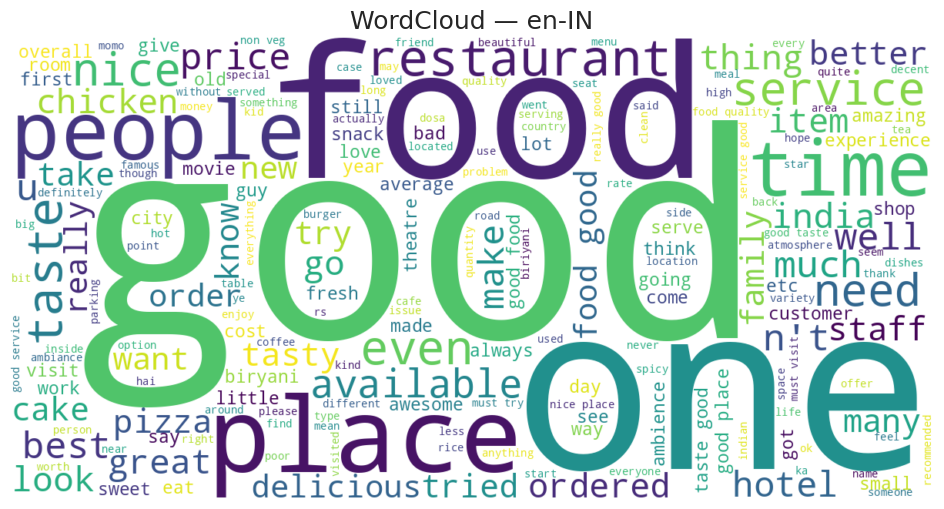

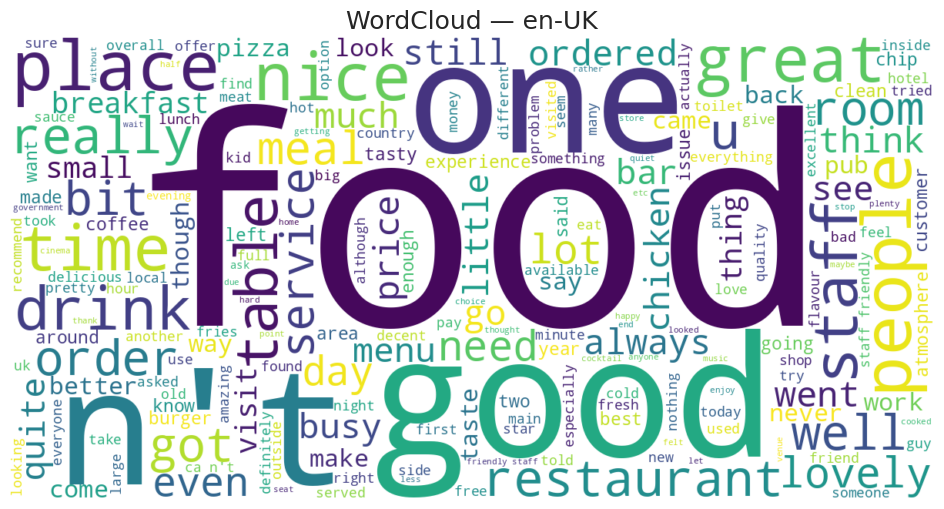

In [16]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import re

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"&\w+;", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train["clean_text"] = train["text"].apply(preprocess)
valid["clean_text"] = valid["text"].apply(preprocess)

stop_words = set(stopwords.words("english"))

def get_text_for_variety(df, variety):
    subset = df[df["variety"] == variety]
    words = [w for w in " ".join(subset["clean_text"]).split() if w not in stop_words]
    return " ".join(words)

def plot_wordcloud(text, title):
    wc = WordCloud(width=1200, height=600, background_color="white").generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=18)
    plt.show()

for v in train["variety"].unique():
    txt = get_text_for_variety(train, v)
    plot_wordcloud(txt, f"WordCloud — {v}")

- **en-AU**: more slang and casual vocabulary.
- **en-IN**: frequent evaluative adjectives (“good”, “nice”), food-related terms.
- **en-UK**: more narrative patterns (“we had”), polite evaluation words.

These differences support the paper’s claim that dialectal variation affects model performance.

---

### Step 4 — Sarcasm vs Non-Sarcasm Bigrams

We compare the most frequent bigrams (2-word phrases) in sarcastic vs non-sarcastic texts. Bigrams reveal linguistic patterns that help classifiers distinguish literal vs ironic language.

In [18]:
# =======================================================
#   SARCASM vs NON-SARCASM BIGRAM ANALYSIS (ONE SCRIPT)
# =======================================================

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


# ------------------- Filter the Data -------------------

# Keep only sarcasm task samples
sar_df = train[train["task"] == "Sarcasm"].reset_index(drop=True)

sar_texts = sar_df[sar_df["label"] == 1]["clean_text"].tolist()
nonsar_texts = sar_df[sar_df["label"] == 0]["clean_text"].tolist()


# ---------------- Helper Function: Extract Top Bigrams ----------------

def get_top_bigrams(texts, n=20):
    """
    Extract the top n bigrams (2-word phrases) using CountVectorizer.
    - Removes English stopwords
    - Only bigrams (ngram_range=2,2)
    - min_df=2 removes extremely rare bigrams
    """
    vectorizer = CountVectorizer(
        stop_words="english",
        ngram_range=(2,2),
        min_df=2
    )

    if len(texts) == 0:
        return pd.DataFrame({"bigram": [], "frequency": []})

    X = vectorizer.fit_transform(texts)
    bigrams = vectorizer.get_feature_names_out()
    freqs = X.sum(axis=0).A1

    df = pd.DataFrame({
        "bigram": bigrams,
        "frequency": freqs
    }).sort_values("frequency", ascending=False)

    return df.head(n)


# ---------------------- Compute Bigram Tables ----------------------

top_sar = get_top_bigrams(sar_texts, n=20)
top_nonsar = get_top_bigrams(nonsar_texts, n=20)

print("Top Bigrams — SARCASTIC TEXTS:\n", top_sar, "\n")
print("Top Bigrams — NON-SARCASTIC TEXTS:\n", top_nonsar, "\n")


# ---------------------- Plotting Function ----------------------

def plot_bigrams(df, title):
    """
    Plots a horizontal bar chart with value labels.
    """
    if df.empty:
        print(f"No bigrams found for: {title}")
        return

    plt.figure(figsize=(9,7))
    ax = sns.barplot(data=df, x="frequency", y="bigram", palette="magma")

    # Add labels on bars
    for i, row in df.iterrows():
        ax.text(row["frequency"] + 0.1, i, str(row["frequency"]),
                color='black', va='center')

    plt.title(title, fontsize=18)
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Bigram", fontsize=14)
    plt.show()

Top Bigrams — SARCASTIC TEXTS:
                 bigram  frequency
573          years ago         12
223       human rights         10
125          don think         10
79         cost living         10
261           just say         10
318         looks like          9
120           don like          9
342      mental health          9
491        sounds like          8
111  domestic violence          8
550             ve got          7
558         war crimes          7
118           don know          7
571           year old          7
332          make sure          7
252           just don          6
248         jus cogens          6
324             mai hi          6
208    health minister          6
158        fossil fuel          6 

Top Bigrams — NON-SARCASTIC TEXTS:
                   bigram  frequency
4045           food good        185
11165     staff friendly        167
10598       service good        137
9727         really good        137
4818          good place        120


- Sarcastic bigrams often contain grammatical mistakes.
- Non-sarcastic bigrams contain straightforward review expressions (“good food”, “nice place”, “staff friendly”).
- This difference highlights why sarcasm is more challenging: it uses positive words in negative contexts.


---

### Step 5 — TF–IDF Keyword Analysis per Variety (en-AU, en-IN, en-UK)

We compute the most important words (high TF–IDF scores) for each English variety. TF–IDF highlights words that are frequent *within a variety* but relatively rare *outside it*.

This helps us understand:
- what lexical patterns differentiate the varieties,
- why models may perform differently across dialects,
- which dialects have unique vocabulary or expressions.

This analysis directly supports the paper's claim that dialectal differences influence model performance.

In [19]:
# ======================================================
#   TF–IDF KEYWORDS PER VARIETY (ONE CLEAN SCRIPT)
# ======================================================

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Prepare text per variety
varieties = ["en-AU", "en-IN", "en-UK"]
variety_texts = {
    v: train[train["variety"] == v]["clean_text"].tolist()
    for v in varieties
}

# Combine all text for global TF-IDF fitting
all_text = train["clean_text"].tolist()

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1,1)
)

tfidf_matrix = vectorizer.fit_transform(all_text)
feature_names = vectorizer.get_feature_names_out()

# Function to compute top TF-IDF terms for a subset
def top_tfidf_keywords(texts, n=20):
    if len(texts) == 0:
        return pd.DataFrame({"term": [], "score": []})

    tfidf_subset = vectorizer.transform(texts)
    mean_scores = tfidf_subset.mean(axis=0).A1

    df = pd.DataFrame({
        "term": feature_names,
        "score": mean_scores
    }).sort_values("score", ascending=False)

    return df.head(n)

# Compute top keywords for each variety
tfidf_results = {
    v: top_tfidf_keywords(variety_texts[v], n=20)
    for v in varieties
}

# Display results
for v in varieties:
    print(f"\nTop TF-IDF keywords for {v}:")
    display(tfidf_results[v])


Top TF-IDF keywords for en-AU:


,term,score
1957,good,0.021504
1985,great,0.019041
2418,just,0.018214
1813,food,0.018019
2600,like,0.016140
3233,people,0.015018
4544,time,0.012957
4205,staff,0.012898
1411,don,0.012894
2987,nice,0.012210



Top TF-IDF keywords for en-IN:


,term,score
1957,good,0.050942
1813,food,0.030651
3298,place,0.025758
4435,taste,0.021992
2600,like,0.016700
3538,quality,0.014969
3981,service,0.014482
2987,nice,0.014457
482,best,0.013242
830,chicken,0.011827



Top TF-IDF keywords for en-UK:


,term,score
1813,food,0.033274
1957,good,0.030135
4205,staff,0.026695
1985,great,0.024304
2987,nice,0.022714
3981,service,0.020258
2418,just,0.019038
1858,friendly,0.017772
2600,like,0.017620
3298,place,0.017405


The TF–IDF keywords highlight which words are **most distinctive** for each English variety. Because TF–IDF penalizes globally frequent words, these top terms represent **variety-specific lexical preferences and linguistic patterns**.

---

🇦🇺 en-AU (Australian English)

**Observed top words:**  
`good`, `great`, `just`, `food`, `like`, `people`, `time`, `staff`, `nice`, `service`, `really`, `place`, `think`, `friendly`

- The vocabulary is **casual and conversational**, typical of Australian online reviews.
- Frequent use of **evaluative adjectives** (`good`, `great`, `nice`, `friendly`).
- Presence of **service-domain keywords** (`staff`, `service`, `food`, `time`) aligns with review culture.
- Words like **“just”, “really”, “think”** indicate a more **opinionated, informal tone**.

---

🇮🇳 en-IN (Indian English)

**Observed top words:**  
`good`, `food`, `place`, `taste`, `like`, `quality`, `service`, `nice`, `best`, `chicken`, `price`, `available`, `restaurant`, `hai`, `tasty`, `veg`

- en-IN has **much stronger emphasis on food-related vocabulary**, matching the dataset’s Google review domain.
- Frequent use of **simple, formulaic positive expressions** (`good`, `nice`, `best`).
- **Price-related terms** (`price`, `available`, `value`) appear more than in AU/UK.
- **“hai”** (Hindi for *is*) and **“veg”** indicate **code-mixing** and **Indian English culinary slang**.
- This reflects the hybrid nature of Indian English reviews:
  - Mixed Hindi–English tokens  
  - Domain-specific restaurant vocabulary  
  - Short, direct evaluative statements

---

🇬🇧 en-UK (British English)

**Observed top words:**  
`food`, `good`, `staff`, `great`, `nice`, `service`, `just`, `friendly`, `like`, `place`, `really`, `people`, `did`, `time`, `lovely`, `atmosphere`, `drinks`, `chicken`, `order`

- en-UK reviews include **narrative and descriptive vocabulary**, such as:
  - `lovely`  
  - `atmosphere`  
  - `order`  
  - `drinks`
- Shows a **polite and descriptive reviewing style**, typical of British English.
- More fine-grained evaluative words like **“lovely”**, which do not appear in AU/IN lists.
- The presence of **narrative past tense markers** (`did`, `order`, `time`) matches the storytelling tone often found in UK reviews.

---

### Step 6 — Sarcasm-Exclusive Lexical Markers

In this step, we identify the words and bigrams that appear **frequently in sarcastic texts** but **rarely or never in non-sarcastic texts**.

This reveals:
- sarcasm-specific vocabulary,
- irony markers,
- exaggeration patterns,
- discourse cues that models must learn.

These words are important because sarcastic messages often use **positive-sounding words** or **short pragmatic cues**, which differ from literal sentiment vocabulary.


In [22]:
# ================================================================
#   SARCASM-EXCLUSIVE WORDS / BIGRAMS (ONE CLEAN SCRIPT)
# ================================================================

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# ------------------------- Prepare Data -------------------------
sar = train[(train["task"] == "Sarcasm") & (train["label"] == 1)]["clean_text"].tolist()
nonsar = train[(train["task"] == "Sarcasm") & (train["label"] == 0)]["clean_text"].tolist()

# ------------------------- Unigram Analysis -------------------------
# Count frequencies
sar_counts = Counter(" ".join(sar).split())
nonsar_counts = Counter(" ".join(nonsar).split())

# Words that appear in sarcasm but not in non-sarcasm
sar_unique = {w: c for w, c in sar_counts.items() if nonsar_counts[w] == 0}

# Top sarcasm-only words
top_sar_unique = sorted(sar_unique.items(), key=lambda x: x[1], reverse=True)[:20]

sar_unique_df = pd.DataFrame(top_sar_unique, columns=["word", "frequency"])
print("🎯 Top Sarcasm-Exclusive Unigrams:")
display(sar_unique_df)

# ------------------------- Bigram Analysis -------------------------
vectorizer = CountVectorizer(stop_words="english", ngram_range=(2,2), min_df=1)

# Fit on sarcastic text only
sar_bigrams = vectorizer.fit_transform(sar)
sar_bigram_counts = dict(zip(vectorizer.get_feature_names_out(), sar_bigrams.toarray().sum(axis=0)))

# Fit on non-sarcastic text
nonsar_bigrams = vectorizer.transform(nonsar)
nonsar_bigram_counts = dict(zip(vectorizer.get_feature_names_out(), nonsar_bigrams.toarray().sum(axis=0)))

# Bigram exclusivity = appears in sarcastic but not in non-sarcastic
sar_bigram_unique = {b: c for b, c in sar_bigram_counts.items() if nonsar_bigram_counts[b] == 0}

# Top sarcasm-exclusive bigrams
top_sar_bigram_unique = sorted(sar_bigram_unique.items(), key=lambda x: x[1], reverse=True)[:20]

sar_bigram_unique_df = pd.DataFrame(top_sar_bigram_unique, columns=["bigram", "frequency"])
print("🔥 Top Sarcasm-Exclusive Bigrams:")
display(sar_bigram_unique_df)

# ------------------------- TF-IDF Exclusivity Score -------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
tfidf_sar = vectorizer.fit_transform(sar)
tfidf_nonsar = vectorizer.transform(nonsar)

feature_names = vectorizer.get_feature_names_out()

# Mean TF-IDF per class
sar_scores = tfidf_sar.mean(axis=0).A1
nonsar_scores = tfidf_nonsar.mean(axis=0).A1

# Exclusivity = TF-IDF_sar - TF-IDF_nonsar
exclusivity = sar_scores - nonsar_scores

ex_df = pd.DataFrame({
    "term": feature_names,
    "exclusivity_score": exclusivity
}).sort_values("exclusivity_score", ascending=False).head(20)

print("💥 Top Sarcasm-Exclusive Terms (TF–IDF Difference):")
display(ex_df)

🎯 Top Sarcasm-Exclusive Unigrams:


,word,frequency
0,carbines,8
1,essay,8
2,populist,6
3,ndis,5
4,mcbride,5
5,unions,5
6,cfmeu,5
7,investigating,5
8,enterprise,5
9,deed,5


🔥 Top Sarcasm-Exclusive Bigrams:


,bigram,frequency
0,conservative party,6
1,health minister,6
2,jus cogens,6
3,mai hi,6
4,mr carbines,6
5,actually doing,5
6,cross legs,5
7,labor seats,5
8,committing crimes,4
9,economic managers,4


💥 Top Sarcasm-Exclusive Terms (TF–IDF Difference):


,term,exclusivity_score
14434,labor,0.003074
2096,australia,0.002592
7739,don,0.002554
15597,lnp,0.002220
8100,dutton,0.001865
10348,gas,0.001702
1207,albo,0.001630
1703,aren,0.001617
17940,news,0.001576
24126,shit,0.001537


The sarcasm-exclusive unigrams and bigrams reveal a very important characteristic of this dataset: **sarcasm in BESSTIE largely expresses political commentary rather than simple ironic praise**.

- Sarcasm in this dataset is **heavily political**, not general-purpose humor.  
- Sarcastic texts reference:
  - politicians,  
  - government programs,  
  - political scandals,  
  - economic debates.  
- Non-sarcastic texts lack this domain-specific vocabulary entirely.  
- There is a **clear separation between political sarcasm vs neutral/literal statements**.  
- Language models need:
  - political world knowledge,  
  - pragmatic cues,  
  - context understanding  
to properly classify these examples.

---

## Summary

Our analysis of sarcasm-exclusive words, bigrams, and TF–IDF scores reveals a crucial structural property of the BESSTIE benchmark:  
**the sarcasm subset is heavily dominated by political content**, rather than general figurative language.

This leads to several important observations:

| Issue | Explanation |
|-------|-------------|
| **Domain imbalance** | Sarcasm examples are overwhelmingly political (e.g., *Labor*, *LNP*, *Dutton*, *health minister*, *carbon emissions*), whereas non-sarcastic examples are mostly Google reviews about food, service, or places. |
| **Topic mismatch** | Sarcastic texts and non-sarcastic texts come from *different domains entirely*, making the task partly a domain-classification problem rather than purely sarcasm detection. |
| **Highly topical sarcastic cues** | Sarcasm uses political references, scandals, and public figures instead of typical irony markers like “yeah right” or “sure”. This means sarcasm often requires **world knowledge** to interpret. |
| **Dialectal overlap** | Many of these political references are tied to Australia and the UK (e.g., *Anthony Carbines*, *CFMEU*, *McBride*, *LNP*), reinforcing dialect-specific sarcasm patterns. |


This structure makes sarcasm detection significantly more difficult **for reasons unrelated to figurative linguistic complexity**.  
Models struggle not because sarcasm is inherently subtle, but because:

- sarcasm examples require **political context**,  
- the dataset mixes **different domains** across classes, and  
- sarcasm is tied to **regional political discourse**, not universal irony cues.

As a result, effective sarcasm detection on BESSTIE may require:
- topic modeling,  
- political knowledge,  
- dialect awareness,  
- or contextual embeddings.

This observation should be considered when interpreting model performance and when designing cross-variety experiments.